In [1]:
# imports
from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add to sys.path
sys.path.insert(0, parent_dir)


In [2]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfgs = [
    c for c in configs if 'simple_exp' in c['name'] 
        and c['config']['dataset']['_target_'] == 'datasets.distribution_datasets.MultivariateNormalDistributionDataset'
        and c['config']['dataset']['set_size'] == 500
]

In [3]:
import hydra
# load + prep dataset
def prepare_dataset(dataset_cfg):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    dataset = hydra.utils.instantiate(dataset_cfg)
    # dataset.probs = probs
    # dataset.data, _, _ = dataset.make_sets()
    return dataset

# load encoder and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

enc, gen = load_model(cfgs[0]['config'], cfgs[0]['dir'], device)


In [4]:
ds = prepare_dataset(cfgs[0]['config']['dataset'])

In [5]:
# s1 = ds.sample(ds.mu[0][None, :], ds.cov[0][None, :, :], 1, 1_000_000, (2,)).squeeze()
# s2 = ds.sample(ds.mu[1][None, :], ds.cov[1][None, :, :], 1, 1_000_000, (2,)).squeeze()

In [5]:
import numpy as np
import torch
s = ds.sample(ds.mu, ds.cov, 1, 100_000, (2,))


In [7]:
# del lat
# clear cuda cache and gc
torch.cuda.empty_cache()
import gc
gc.collect()


483

In [19]:
batch_size = 100
# batch to avoid memory issues
lat = []
for i in range(0, s.shape[0], batch_size):
    print(i)
    with torch.no_grad():
        lat.append(enc(torch.from_numpy(s[i:i+batch_size]).float().to(device)).cpu().numpy())
lat = np.concatenate(lat, axis=0)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [27]:
def wasserstein_distance(mu, cov):
    mean_dist = np.linalg.norm(mu[:, None, :] - mu[None, :, :], axis=2)
    var_dist = np.zeros((mu.shape[0], mu.shape[0]))
    for i, cov_i in enumerate(cov):
        for j, cov_j in enumerate(cov):
            var_dist[i, j] = np.trace(cov_i + cov_j - 2 * sp.linalg.sqrtm(sp.linalg.sqrtm(cov_i) @ cov_j @ sp.linalg.sqrtm(cov_i)))
    return mean_dist + var_dist

In [28]:
np.trace(ds.cov[0])

0.45435029246084024

In [ ]:
w2_dist = wasserstein_distance(ds.mu, ds.cov)

In [ ]:
# compute spearman correlation between lat and w2_dist
import scipy as sp
spearman_corr = sp.stats.spearmanr(lat, w2_dist)[0]
spearman_corr


In [21]:
import scipy as sp
np.linalg.cholesky(ds.cov[:5]), sp.linalg.sqrtm(ds.cov[:5])

ValueError: Non-matrix input to matrix function.

In [44]:
import numpy as np
import torch
lat = enc(torch.from_numpy(np.concatenate([s1[None, :, :], s2[None, :, :]], axis=0)).float().to(device))
# resample = gen.sample(lat, 1_000_000, return_trajectory=False)
# linearly interpolate between the two points
lat_interp = lat[0] + (lat[1] - lat[0]) * torch.linspace(0, 1, 10)[:, None].to(device)
resample = gen.sample(lat_interp, 1_000_000, return_trajectory=False)


In [46]:
import numpy as np

# X is (n, m, d)
def vectorized_covariance(X):
    # Center the data
    X_centered = X - X.mean(axis=1, keepdims=True)  # shape (n, m, d)

    # Compute covariance: cov = (X^T X) / (m - 1)
    cov = np.einsum('nmd,nme->nde', X_centered, X_centered) / (X.shape[1] - 1)
    return cov


# compute means and covariances of all the resampled points
resample_means = np.mean(resample.cpu().numpy(), axis=1)
resample_covs = vectorized_covariance(resample.cpu().numpy())

In [77]:
import numpy as np
from scipy.linalg import sqrtm

import numpy as np
from scipy.linalg import sqrtm

def generate_ot_trajectory(mean1, cov1, mean2, cov2, n_steps=10):
    """
    Generate the correct Optimal Transport trajectory between two Gaussian distributions.
    
    Parameters:
    -----------
    mean1 : array-like
        Initial mean (2D vector)
    cov1 : array-like
        Initial covariance matrix (2x2)
    mean2 : array-like
        Final mean (2D vector)
    cov2 : array-like
        Final covariance matrix (2x2)
    n_steps : int
        Number of interpolation steps
        
    Returns:
    --------
    means : array-like
        List of interpolated means
    covs : array-like
        List of interpolated covariance matrices
    """
    mean1 = np.array(mean1)
    mean2 = np.array(mean2)
    cov1 = np.array(cov1)
    cov2 = np.array(cov2)
    
    # Generate interpolation parameters
    ts = np.linspace(0, 1, n_steps)
    
    # Initialize lists for means and covariances
    means = []
    covs = []
    
    # Compute the square root of cov1
    sqrt_cov1 = sqrtm(cov1)
    inv_sqrt_cov1 = np.linalg.inv(sqrt_cov1)
    
    # Compute A = (cov1^(1/2) * cov2 * cov1^(1/2))^(1/2)
    A = sqrtm(sqrt_cov1 @ cov2 @ sqrt_cov1)
    
    for t in ts:
        # Interpolate means linearly
        mean_t = (1 - t) * mean1 + t * mean2
        
        # Correct interpolation formula for covariances
        inner = ((1 - t) * cov1 + t * sqrtm(sqrt_cov1 @ cov2 @ sqrt_cov1))
        cov_t = inv_sqrt_cov1 @ (inner @ inner) @ inv_sqrt_cov1
        
        means.append(mean_t)
        covs.append(cov_t)
    
    return np.array(means), np.array(covs)

ot_means, ot_covs = generate_ot_trajectory(ds.mu[0], ds.cov[0], ds.mu[1], ds.cov[1], 10)

In [78]:
resample_means, ot_means

(array([[0.37305936, 0.93520147],
        [0.41158053, 0.8951678 ],
        [0.45083582, 0.8589351 ],
        [0.48942858, 0.81978625],
        [0.5285292 , 0.78249896],
        [0.5682856 , 0.74611026],
        [0.6087502 , 0.7083183 ],
        [0.64849496, 0.66991925],
        [0.6878058 , 0.6313785 ],
        [0.7272816 , 0.5927901 ]], dtype=float32),
 array([[0.37454012, 0.95071431],
        [0.41425721, 0.91159699],
        [0.4539743 , 0.87247968],
        [0.49369139, 0.83336237],
        [0.53340848, 0.79424505],
        [0.57312558, 0.75512774],
        [0.61284267, 0.71601042],
        [0.65255976, 0.67689311],
        [0.69227685, 0.6377758 ],
        [0.73199394, 0.59865848]]))

In [79]:
ds.cov[1]

array([[ 0.14166764, -0.04377504],
       [-0.04377504,  0.20535063]])

In [80]:
resample_covs[-1], ot_covs[-1]

(array([[ 0.13944064, -0.04221113],
        [-0.04221113,  0.21621837]]),
 array([[ 0.14166764, -0.04377504],
        [-0.04377504,  0.20535063]]))

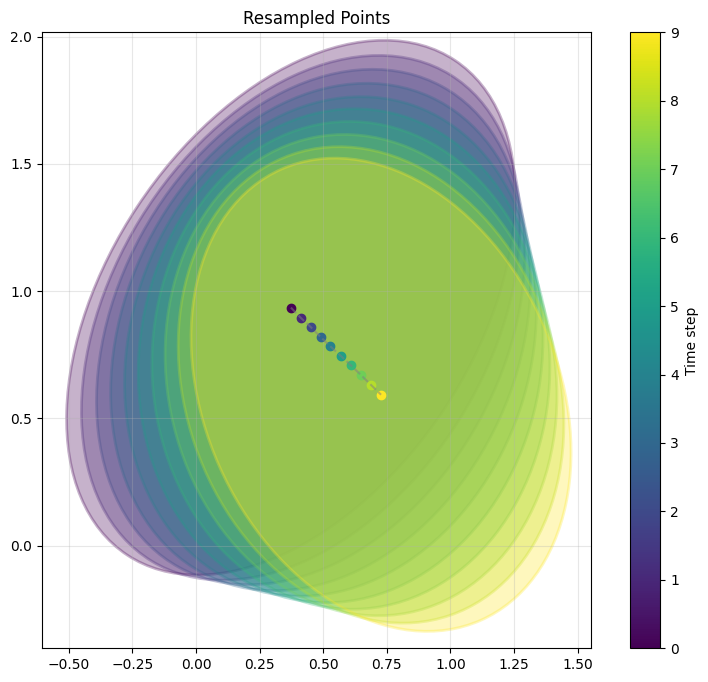

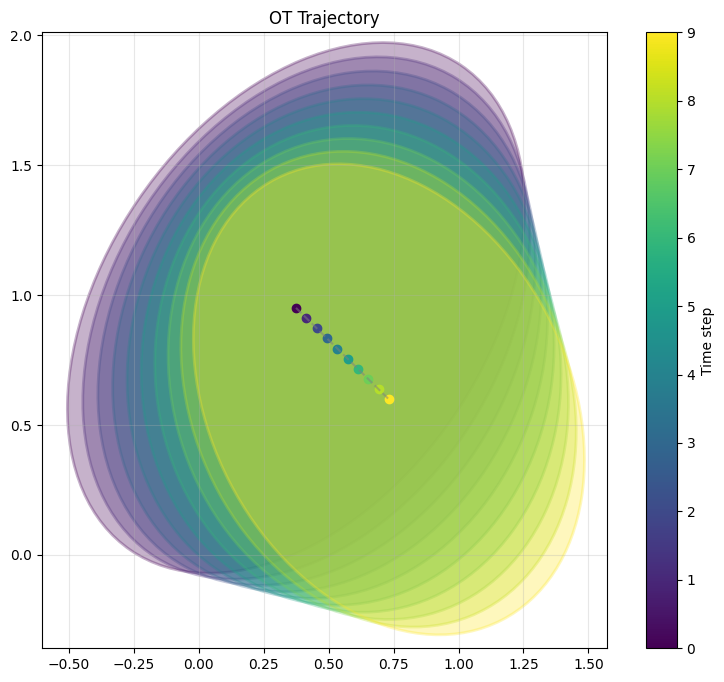

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.colors as mcolors

def plot_gaussian_trajectories(means, covs, figsize=(10, 8), alpha=0.3, n_std=2):
    """
    Plot trajectories of Gaussian distributions with their confidence ellipses.
    
    Parameters:
    -----------
    means : array-like
        List of 2D means, shape (n_timesteps, 2)
    covs : array-like
        List of 2x2 covariance matrices, shape (n_timesteps, 2, 2)
    figsize : tuple
        Figure size (width, height)
    alpha : float
        Transparency of ellipses
    n_std : float
        Number of standard deviations for ellipse size
    """
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create color gradient
    colors = plt.cm.viridis(np.linspace(0, 1, len(means)))
    
    # Plot trajectories and ellipses
    for i in range(len(means)):
        mean = means[i]
        cov = covs[i]
        
        # Calculate eigenvalues and eigenvectors
        eigenvals, eigenvecs = np.linalg.eigh(cov)
        
        # Calculate angle and axes lengths for ellipse
        angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
        width, height = 2 * n_std * np.sqrt(eigenvals)
        
        # Create and add ellipse
        ellipse = Ellipse(xy=mean,
                         width=width,
                         height=height,
                         angle=angle,
                         facecolor=colors[i],
                         alpha=alpha,
                         edgecolor=colors[i],
                         linewidth=2)
        ax.add_patch(ellipse)
        
        # Plot mean point
        ax.plot(mean[0], mean[1], 'o', color=colors[i], markersize=6)
        
    # Plot trajectory line
    means_array = np.array(means)
    ax.plot(means_array[:, 0], means_array[:, 1], '--', color='gray', alpha=0.5)
    
    # Set equal aspect ratio and grid
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar to show time progression
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                              norm=plt.Normalize(vmin=0, vmax=len(means)-1))
    plt.colorbar(sm, ax=ax, label='Time step')  # Added ax=ax here
    
    return fig, ax


fig, ax = plot_gaussian_trajectories(resample_means, resample_covs)
# add title
ax.set_title('Resampled Points')
fig_ot, ax_ot = plot_gaussian_trajectories(ot_means, ot_covs)
# add title
ax_ot.set_title('OT Trajectory')

plt.show()


In [ ]:
ot_covs